In [1]:
import pandas as pd
import pandas as pd
# 데이터 로드
dir = './data/'
files = ['오픈공격', '시간차공격', '이동공격', '후위공격', '속공', '퀵오픈']

# 데이터프레임을 저장할 리스트
dfs = []

for file in files:
    df = pd.read_csv(f'{dir}kovo_men_{file}.csv')
    df['공격유형'] = file  # ✅ 각 DataFrame에 공격유형 추가
    dfs.append(df)

# 수직 병합
df_total = pd.concat(dfs, ignore_index=True)

df_total

,순서,선수,포지션,전체팀,경기수,세트수,시도,성공,실패,범실,성공률,공격유형
0,1,레오,OH,현대캐피탈,36,130,415,187,23,36,45.06,오픈공격
1,2,비예나,OP,KB손해보험,35,136,383,163,45,19,42.56,오픈공격
2,3,파즐리,OP,삼성화재,34,124,312,133,38,26,42.63,오픈공격
3,4,김지한,OH,우리카드,35,128,317,117,33,31,36.91,오픈공격
4,5,허수봉,OH,현대캐피탈,35,126,277,112,28,24,40.43,오픈공격
...,...,...,...,...,...,...,...,...,...,...,...,...
175,26,야쿱,OH,KB손해보험,14,48,151,77,12,11,50.99,퀵오픈
176,27,김우진,OH,삼성화재,30,75,157,77,31,8,49.04,퀵오픈
177,28,장빙롱,OH,OK저축은행,17,50,152,75,16,7,49.34,퀵오픈
178,29,송희채,OH,OK저축은행,26,74,163,71,24,12,43.56,퀵오픈


In [2]:
# 공격다양성(ADI) 산출을 위한 피벗테이블
pivot = pd.pivot_table(
    df_total,
    index='선수',                                # 행: 선수
    columns='공격유형',                          # 열: 공격 유형이 차원으로
    values=['세트수', '시도', '성공', '실패', '범실', '성공률'],  # 집계 대상
    aggfunc='sum',                               # 합계 기준
    fill_value=0
)

# 보기 좋게 컬럼 정리 (MultiIndex → 단일 컬럼명)
pivot.columns = [f'{val}_{col}' for val, col in pivot.columns]
pivot = pivot.reset_index()

In [3]:
import numpy as np
import pandas as pd

# 0) df 준비 (pivot을 쓰셨다면 df로 통일)
df = pivot.copy()

# 1) 컬럼 표준화: 공백 제거
df = df.copy()
df.columns = df.columns.str.replace(' ', '', regex=False)

# 2) '시도_'로 시작하는 공격유형별 시도 열 자동 탐색
attempt_cols = [c for c in df.columns if c.startswith('시도_')]
if len(attempt_cols) == 0:
    raise ValueError("시도_ 로 시작하는 열이 없습니다. 컬럼명을 확인하세요.")

# 3) 총 시도
df['총시도'] = df[attempt_cols].sum(axis=1)

# 4) 비율 p_i (총시도=0인 경우 0 처리)
probs = df[attempt_cols].div(df['총시도'].replace(0, np.nan), axis=0).fillna(0)

# 5) ADI = -Σ p_i * log2(p_i) (p_i=0은 무시)
probs_nonzero = probs.replace(0, np.nan)
df['ADI'] = -(probs_nonzero * np.log2(probs_nonzero)).sum(axis=1).fillna(0)

# 핕터링
df_adi  = df[['선수','ADI']]
df_adi


,선수,ADI
0,강승일,-0.000000
1,곽승석,-0.000000
2,구교혁,1.310884
3,그로즈다노프,0.938093
4,김건우,0.819965
...,...,...
83,파즐리,1.710413
84,한선수,-0.000000
85,한성정,-0.000000
86,허수봉,1.550558


In [4]:
# AER, ER 지표 산출
df_men_attack = pd.read_csv('data/kovo_men_attack.csv')
df_men_attack['AER'] = df_men_attack['시도'] / df_men_attack['세트수']
df_men_attack['ER'] = df_men_attack['범실'] / df_men_attack['시도']
#필터링
df_AER_ER = df_men_attack[['선수','팀','AER','ER']]
#병합
df3 = pd.merge(df_adi,df_AER_ER,how='inner',on='선수')

In [5]:
#AEI, OIDR 산출
df_man_team = pd.read_csv('data/kovo_man_team.csv')
df_man_team = df_man_team.rename(columns={'성공률':'팀_성공률'})

df_AEI = df_men_attack.merge(df_man_team[['팀','팀_성공률']],how='left',on='팀')
df_AEI['AEI'] = df_AEI['성공률']/df_AEI['팀_성공률']
df_AEI = df_AEI[['선수','AEI']]
df_oidr = pd.merge(df3,df_AEI,on='선수',how='inner')
df_oidr


,선수,ADI,팀,AER,ER,AEI
0,구교혁,1.310884,한국전력,5.034884,0.108545,0.983620
1,그로즈다노프,0.938093,삼성화재,8.000000,0.067500,0.927028
2,김동영,1.588111,한국전력,3.118644,0.097826,1.057125
3,김민재,-0.000000,대한항공,2.538462,0.054545,1.225858
4,김우진,1.293373,삼성화재,5.133333,0.072727,1.030141
5,김정호,1.567790,삼성화재,5.008547,0.080205,0.981360
6,김지한,1.509995,우리카드,6.429688,0.076549,0.919471
7,나경복,1.491406,KB손해보험,6.284553,0.060802,0.963820
8,니콜리치,1.571347,우리카드,7.012346,0.072183,0.883486
9,레오,1.512977,현대캐피탈,8.469231,0.066303,0.993806


In [6]:
from sklearn.preprocessing import StandardScaler
# 표준화 적용
ss = StandardScaler()
ss_df_oidr = ss.fit_transform(df_oidr.select_dtypes(include='number'))

# 지표 데이터셋 구축
df_oidr_ss = pd.DataFrame()
df_oidr_ss[['선수','팀']] = df_oidr[['선수','팀']]
df_oidr_ss[['ADI','AER','ER','AEI']] = ss_df_oidr
df_oidr_ss

,선수,팀,ADI,AER,ER,AEI
0,구교혁,한국전력,0.077689,-0.325467,2.401295,-0.242777
1,그로즈다노프,삼성화재,-0.700755,1.059225,-0.540585,-0.932717
2,김동영,한국전력,0.656584,-1.220340,1.633020,0.653354
3,김민재,대한항공,-2.659640,-1.491282,-1.469094,2.710434
4,김우진,삼성화재,0.041125,-0.279492,-0.165923,0.324376
5,김정호,삼성화재,0.614151,-0.337766,0.370023,-0.270326
6,김지한,우리카드,0.493465,0.325898,0.108012,-1.024842
7,나경복,KB손해보험,0.454649,0.258121,-1.020655,-0.484163
8,니콜리치,우리카드,0.621578,0.597996,-0.204926,-1.463552
9,레오,현대캐피탈,0.499691,1.278353,-0.626353,-0.118592


In [8]:
# OIDR 산출
df_oidr_ss['OCI'] = df_oidr_ss['ADI']*0.25 + df_oidr_ss['AEI'] *0.4 + df_oidr_ss['AER']*0.25 - df_oidr_ss['ER']*0.1
OCI = df_oidr_ss[['선수','팀','OCI']].sort_values(by='OCI',ascending=False).reset_index(drop=True)
OCI

,선수,팀,OCI
0,비예나,KB손해보험,1.016532
1,파즐리,삼성화재,0.786129
2,신호진,OK저축은행,0.771642
3,요스바니,대한항공,0.667835
4,알리,우리카드,0.579222
5,레오,현대캐피탈,0.459710
6,허수봉,현대캐피탈,0.392037
7,송명근,우리카드,0.225349
8,김민재,대한항공,0.193352
9,막심,대한항공,0.136663


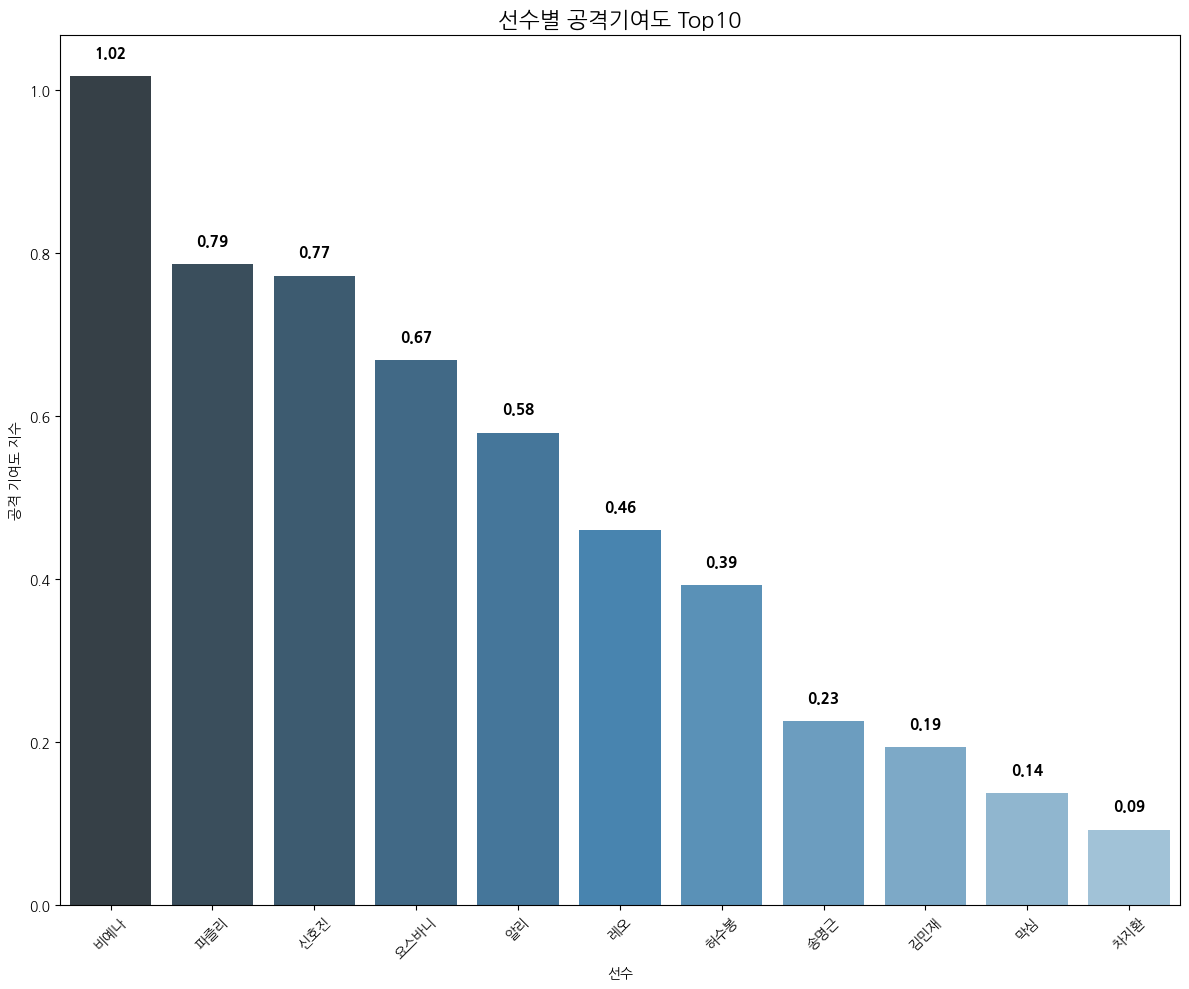

<Figure size 640x480 with 0 Axes>

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

top10 = OCI.loc[:10, :]

plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(12, 10))
colors = sns.color_palette("Blues_d", len(top10))[::-1]
ax = sns.barplot(x='선수', y='OCI', data=top10, palette=colors)

# 각 막대 위에 라벨 표시
for i, row in enumerate(top10.itertuples()):
    plt.text(i, row.OCI + 0.02,        # y위치는 막대 위로 약간 띄움
             f"{row.OCI:.2f}",         # 소수점 둘째자리까지
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.title('선수별 공격기여도 Top10', fontsize=16)
plt.xlabel('선수')
plt.ylabel('공격 기여도 지수')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.savefig('남자선수 공격기여도 파워랭킹.png')

In [10]:
team_count = top10['팀'].value_counts()
team_count

팀
대한항공      3
OK저축은행    2
우리카드      2
현대캐피탈     2
KB손해보험    1
삼성화재      1
Name: count, dtype: int64

- 60%는 플옵 진출, 40%는 탈락

In [11]:
import plotly.graph_objects as go
from ipywidgets import interact

# 방사형차트 함수 정의
def radar_chart(player):
    row = df_oidr_ss[df_oidr_ss['선수'] == player].iloc[0]
    categories = ['ADI', 'AER', 'ER', 'AEI','OCI']
    values = [row[c] for c in categories]
    values += values[:1]  # 닫힌 형태 만들기

    fig = go.Figure(
        data=[go.Scatterpolar(r=values, theta=categories + [categories[0]],
                              fill='toself', name=player)],
        layout=go.Layout(title=f"{player}의 공격 영향 및 다양성 프로파일",
                         polar=dict(radialaxis=dict(visible=False, range=[-10, 10])))
    )
    fig.show()

# 동적 필터 (선수명 선택)
interact(radar_chart, player=df_oidr_ss['선수'].unique())

interactive(children=(Dropdown(description='player', options=('구교혁', '그로즈다노프', '김동영', '김민재', '김우진', '김정호', '김지…

<function __main__.radar_chart(player)>

In [15]:
df_oidr_ss.to_csv('남자부_지표.csv',encoding='utf-8',index=False)
OCI.to_csv('남자부_파워랭킹.csv',encoding='utf-8')

In [14]:
df_oidr_ss

,선수,팀,ADI,AER,ER,AEI,OCI
0,구교혁,한국전력,0.077689,-0.325467,2.401295,-0.242777,-0.399185
1,그로즈다노프,삼성화재,-0.700755,1.059225,-0.540585,-0.932717,-0.229411
2,김동영,한국전력,0.656584,-1.220340,1.633020,0.653354,-0.042899
3,김민재,대한항공,-2.659640,-1.491282,-1.469094,2.710434,0.193352
4,김우진,삼성화재,0.041125,-0.279492,-0.165923,0.324376,0.086751
5,김정호,삼성화재,0.614151,-0.337766,0.370023,-0.270326,-0.076036
6,김지한,우리카드,0.493465,0.325898,0.108012,-1.024842,-0.215897
7,나경복,KB손해보험,0.454649,0.258121,-1.020655,-0.484163,0.086593
8,니콜리치,우리카드,0.621578,0.597996,-0.204926,-1.463552,-0.260034
9,레오,현대캐피탈,0.499691,1.278353,-0.626353,-0.118592,0.459710


In [16]:
df_oidr

,선수,ADI,팀,AER,ER,AEI
0,구교혁,1.310884,한국전력,5.034884,0.108545,0.983620
1,그로즈다노프,0.938093,삼성화재,8.000000,0.067500,0.927028
2,김동영,1.588111,한국전력,3.118644,0.097826,1.057125
3,김민재,-0.000000,대한항공,2.538462,0.054545,1.225858
4,김우진,1.293373,삼성화재,5.133333,0.072727,1.030141
5,김정호,1.567790,삼성화재,5.008547,0.080205,0.981360
6,김지한,1.509995,우리카드,6.429688,0.076549,0.919471
7,나경복,1.491406,KB손해보험,6.284553,0.060802,0.963820
8,니콜리치,1.571347,우리카드,7.012346,0.072183,0.883486
9,레오,1.512977,현대캐피탈,8.469231,0.066303,0.993806
